# Amazon Product Review Feature Engineering Notebook

The purpose of this notebook is to perform some feature engineering on the Amazon Product Review Data. The overall scope of this project is to determine if product reviews on Amazon.com have any sort of impact on the overall sales ranking of any particular item. The data was obtain with permission from the following paper:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
#First import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
#First load the data

rev = pd.read_csv('Data/ProcessedAmazonReviewData120k.csv', index_col=False)
rev.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,title,brand,rank,main_cat,price,rankCat,catRank,Ranking,salesRanking,ratingPrice
0,3.0,True,"06 5, 2018",AB8N9W39H9BAC,B0105RZL7Y,Honest reviewer,Very thin so you don't receive much foot comfort.,VERY THIN,1528156800,"['Home & Kitchen', 'Bath', 'Bath Rugs']",VANRA Bath Mat Bath Rugs Anti-Slip Bath Mats A...,VANRA,"['>#140,213 in Home & Kitchen (See Top 100 in ...",Amazon Home,14.98,"[""140,213 in Home & Kitchen (See Top 100 in Ho...",392 in Home & Kitchen > Bath > Bath Rugs'],392.0,829.0,44.94
1,5.0,True,"08 29, 2015",A3E2ILUDLAWC99,B00VK1NICU,Tiffany Jauregui,Love this product. I like the different cuts i...,Love this product,1440806400,"['Home & Kitchen', 'Kitchen & Dining', 'Kitche...",ChefLand Tri Blade Vegetable Spiral Slicer wit...,ChefLand,"['>#259,204 in Kitchen & Dining (See Top 100 i...",Amazon Home,42.52,"[""259,204 in Kitchen & Dining (See Top 100 in ...",729 in Kitchen & Dining > Kitchen Utensils & G...,729.0,492.0,212.60
2,3.0,True,"05 2, 2017",A1NCMYTS1OI1C1,B019G1YO5A,Adam Nye,"Burns well, but has a slight chemical smell. P...",Smells chemically,1493683200,"['Home & Kitchen', 'Home Dcor', 'Home Fragranc...",Alternative Imagination Premium Palo Santo Hol...,Alternative Imagination,"['>#3,148 in Home & Kitchen (See Top 100 in Ho...",Amazon Home,7.49,"[""3,148 in Home & Kitchen (See Top 100 in Home...",8 in Home & Kitchen > Home Dcor > Home Fragran...,8.0,1213.0,22.47
3,5.0,True,"06 6, 2016",A2K04IC9L96HV8,B006H37I4K,D J E,Just what I ordered and the color was perfect,Five Stars,1465171200,"['Home & Kitchen', 'Bath', 'Towels', 'Fingerti...","Avanti Linens Sand Shells FINGERTIP, Medium, M...",Avanti Linens,"['>#263,473 in Home & Kitchen (See Top 100 in ...",Amazon Home,10.99,"[""263,473 in Home & Kitchen (See Top 100 in Ho...",68 in Home & Kitchen > Bath > Towels > Fingert...,68.0,1153.0,54.95
4,4.0,True,"03 4, 2014",AZNQXK1WHFQIO,B001802PIQ,NWSteph83,Grinds coffee beans however you want it if you...,Awesome grinder,1393891200,"['Home & Kitchen', 'Kitchen & Dining', 'Coffee...",Hario Skerton Ceramic Coffee Mill (100g),Hario,"['>#1,807 in Kitchen & Dining (See Top 100 in ...",Amazon Home,39.50,"[""1,807 in Kitchen & Dining (See Top 100 in Ki...",2 in Home & Kitchen > Kitchen & Dining > Coffe...,2.0,1219.0,158.00


The first feature to add to the data set will be the average rating for each product. However, due to the volume of items available on the Amazon marketplace, I suspect there will be quite a few items that will only have one review. We'll take a look at the number of unique items and the overall number of items. 

In [3]:
print('The number of duplicate reviews is:', rev.shape[0]-len(rev['asin'].unique()))
print('The number of unique items reviewed is:', len(rev.asin.unique()))

The number of duplicate reviews is: 50925
The number of unique items reviewed is: 29012


In [4]:
rev.main_cat.value_counts()

Amazon Home                                                                                                                                                                 75951
Tools & Home Improvement                                                                                                                                                     1803
Industrial & Scientific                                                                                                                                                       386
Toys & Games                                                                                                                                                                  354
Arts, Crafts & Sewing                                                                                                                                                         288
Office Products                                                                                               

In [5]:
#In order to ensure the I want to ignore any categories that only appear a couple times. This will ensure that there are no
#surprise categorical variables in the split data set.
filtered = rev.groupby('main_cat')['asin'].filter(lambda x: len(x) > 80)
rev = rev[rev['asin'].isin(filtered)]

It appears about half of the products have been reviewed more than once, but that shouldn't be an issue for this review. I'll calculate the average rating as well as the count of the reviews. 

In [6]:
rev['AvgRating'] = rev['overall'].groupby(rev.asin).transform('mean')
rev['RatingCount'] = rev['overall'].groupby(rev.asin).transform('sum')

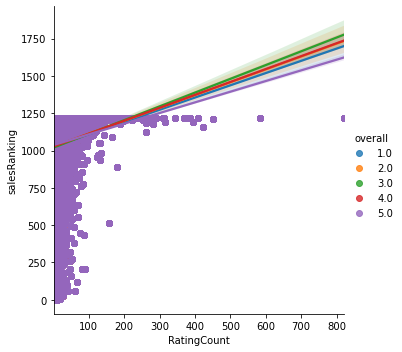

In [7]:
sns.lmplot(x = 'RatingCount', y = 'salesRanking', data = rev, hue = 'overall')


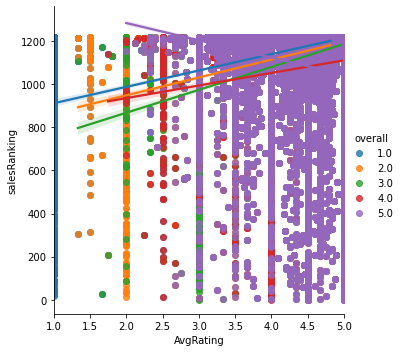

In [8]:
sns.lmplot(x='AvgRating', y = 'salesRanking', data = rev, hue = 'overall')

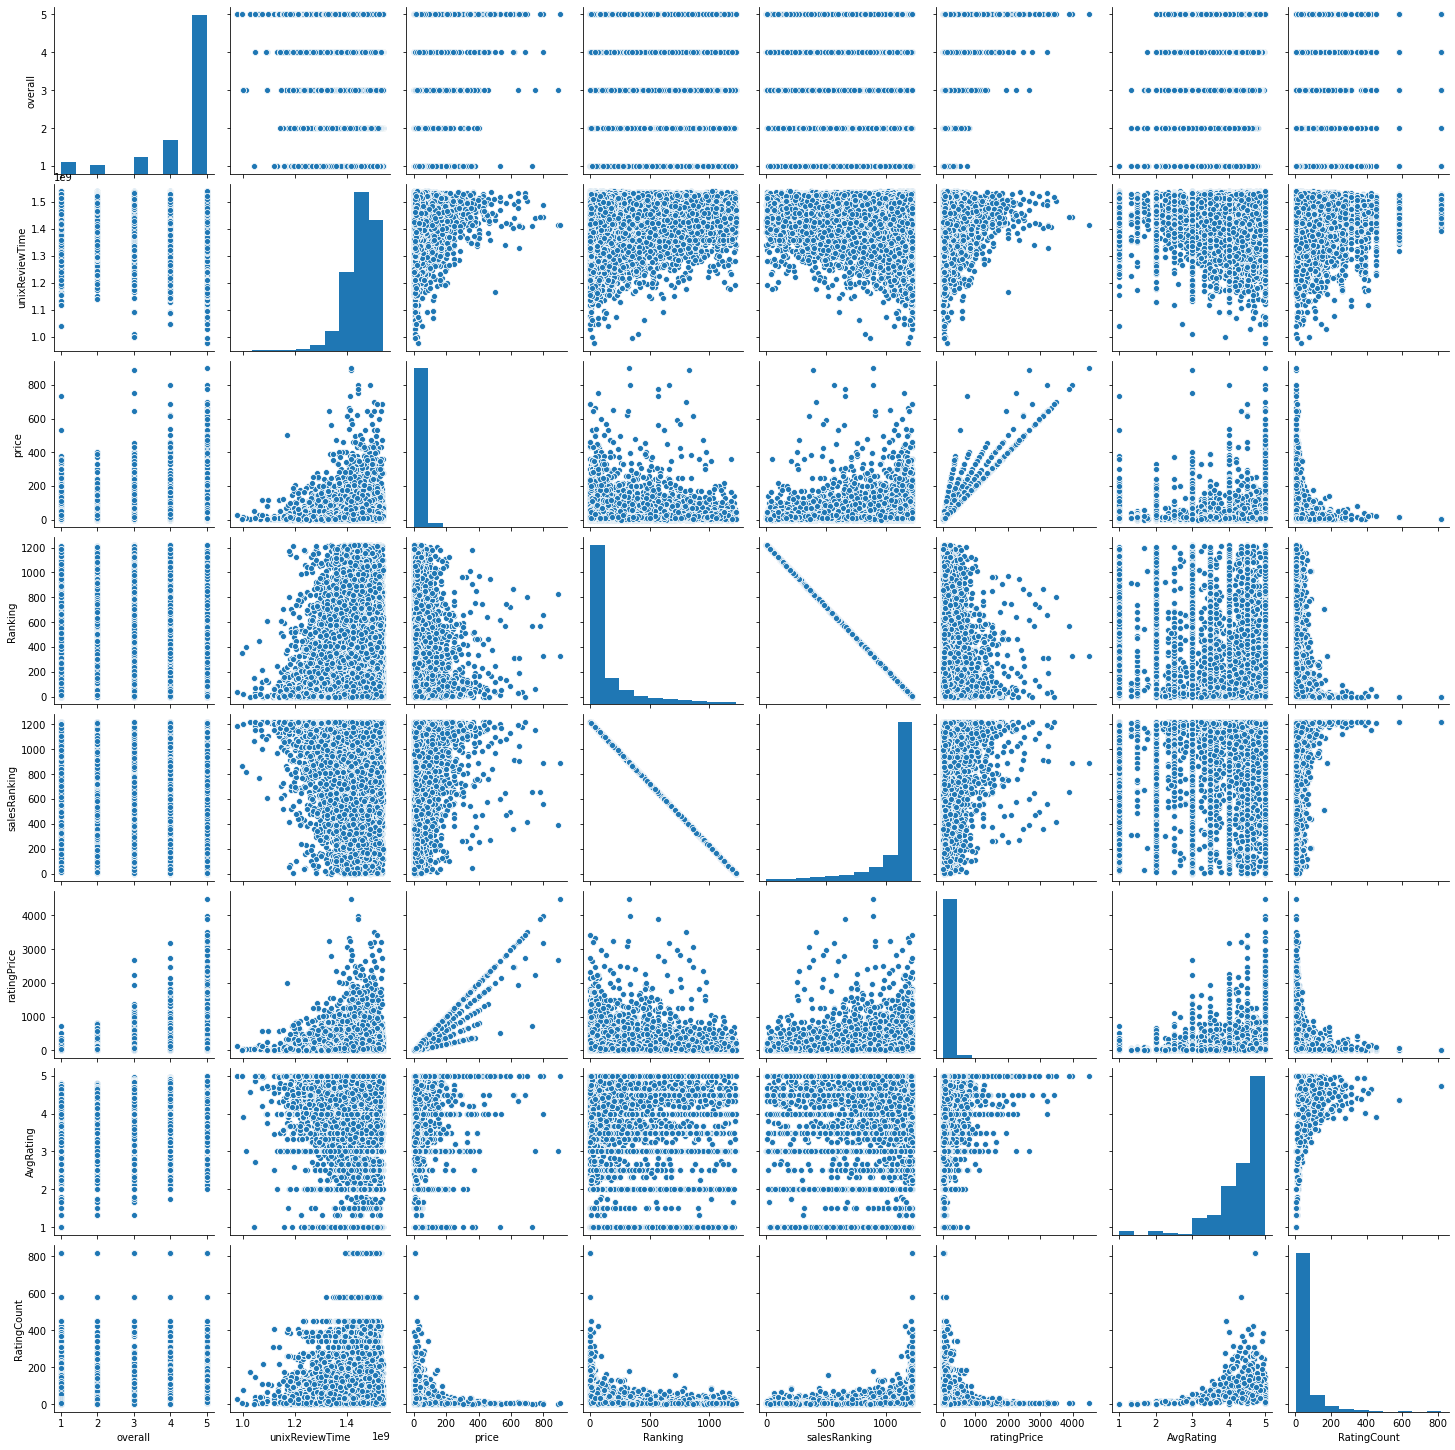

In [9]:
sns.pairplot(rev.drop('verified', axis = 1))

Next I want to create a continuous variable to reflect the sentiment of the review. 
This function will utilize the VADER sentiment analyzer and will average the sentiment of all sentances
in the review. The final variable will be the average of the compound score reported by VADER.

In [10]:
#First I need to import the subjectivity and VADER packages from nltk
import nltk
from nltk.corpus import subjectivity
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#The function creates an instance of the sentiment analyzer and tokenizes the review into sentances. 
#the sentiment of each sentance is stored in a list and the mean of the compound score is taken and returned. 
#If the review contains no text, then 0 is returned (equivalent of a neutral review)
def getSentiment(review):
    sid = SentimentIntensityAnalyzer()
    if len(review) == 0:
        return 0
    elif len(tokenize.sent_tokenize(review)) == 1:
        return sid.polarity_scores(review)['compound']
    sentiment = []
    for sentance in tokenize.sent_tokenize(review):
        ss = sid.polarity_scores(sentance)
        sentiment.append(ss['compound'])
    return np.mean(sentiment)

In [11]:
#Now apply the function to the dataframe and store the results in a new column. 
rev['reviewSentiment'] = rev['reviewText'].apply(getSentiment)

In [12]:
#Next I'd like to get the sentiment of the summary. Hopefully these values are similar...
rev['summarySentiment'] = rev['summary'].apply(getSentiment)

In [13]:
rev.summarySentiment.fillna(value = 0, inplace = True)
pd.isnull(rev).sum()

overall             0
verified            0
reviewTime          0
reviewerID          0
asin                0
reviewerName        0
reviewText          0
summary             0
unixReviewTime      0
category            0
title               0
brand               0
rank                0
main_cat            0
price               0
rankCat             0
catRank             0
Ranking             0
salesRanking        0
ratingPrice         0
AvgRating           0
RatingCount         0
reviewSentiment     2
summarySentiment    0
dtype: int64

In [14]:
rev.dropna(axis=0, how = 'any', inplace = True)

In [15]:
rev.describe()

,overall,unixReviewTime,price,Ranking,salesRanking,ratingPrice,AvgRating,RatingCount,reviewSentiment,summarySentiment
count,79718.000000,7.971800e+04,79718.000000,79718.000000,79718.000000,79718.000000,79718.000000,79718.000000,79718.000000,79718.000000
mean,4.386763,1.452763e+09,24.437001,153.248789,1067.751211,107.681657,4.386762,46.141373,0.326841,0.255351
std,1.110746,5.507161e+07,32.857564,242.124952,242.124952,150.811974,0.726404,76.406768,0.277040,0.326102
min,1.000000,9.769248e+08,0.050000,1.000000,0.000000,0.050000,1.000000,1.000000,-0.944700,-0.850400
25%,4.000000,1.423440e+09,9.590000,9.000000,1043.000000,39.000000,4.000000,9.000000,0.137475,0.000000
50%,5.000000,1.461024e+09,15.950000,43.500000,1177.500000,69.950000,4.562500,20.000000,0.333733,0.205700
75%,5.000000,1.491178e+09,26.760000,178.000000,1212.000000,119.950000,5.000000,50.000000,0.539350,0.571900
max,5.000000,1.538438e+09,899.000000,1221.000000,1220.000000,4495.000000,5.000000,821.000000,0.996200,0.966600


In [16]:
#Next I want to create a variable to capture the length of the review to determine if the length has any impact on the Ranking. 

#Create a regex tokenizer to drop punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
#Now apply the tokenizer to each review and count the lenth
rev['reviewLength'] = rev['reviewText'].apply(lambda x: len(tokenizer.tokenize(x)) if len(x) > 0 else 0)

<AxesSubplot:>

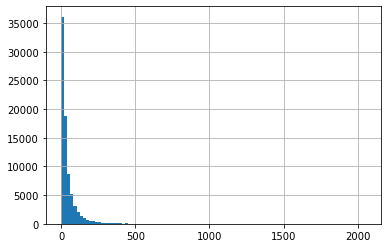

In [17]:
#Lets have a look at the results:
rev['reviewLength'].hist(bins=100)

In [18]:
#Lastly I need to convert 'verified' from boolean to binary.

rev.verified.replace({True:1, False:0}, inplace=True)

I'm curious to see if there are any hidden patterns in the data that I can use as a predictor variable. I'll use the KMeans clustering algorithm from sklearn to engineer some clusters. The first step will be to determine the number of clusters to use. I'll accomplish this using the elbow plot method. First I need to create an X vector for the KMeans algorithm. Then I'll test the variance explained by 1 to 50 clusters. Once we have the clusters we can append them to the data and look for interaction terms.

In [19]:
#First I need to prepare the data for the KMeans algorithm. I'll start by dropping categorical columns. 
#I also need to split the data into train and test groups. 

x_train, x_test, y_train, y_test = train_test_split(rev.drop(['salesRanking'], axis=1), rev.salesRanking, )

obs = []
[obs.append(col) for col in x_train.columns if rev[col].dtype == 'O']
xClf = x_train.drop(obs, axis = 1)

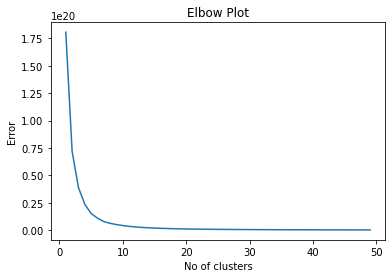

In [20]:
#Run through the number of clusters ranging form 1 to 50. 

from sklearn.cluster import KMeans
Error = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(xClf)
    Error.append(kmeans.inertia_)
plt.plot(range(1, 50), Error)
plt.title('Elbow Plot')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [21]:
#I'll plan to use 8 clusters. Now I need to generate the features and append them to the dataframe. 
kmeans = KMeans(n_clusters = 8, random_state = 123)
kmeans.fit(xClf)
clusters = kmeans.predict(xClf)
x_train['clusters'] = clusters

In [22]:
x_train.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'catRank',
       'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount', 'reviewSentiment',
       'summarySentiment', 'reviewLength', 'clusters'],
      dtype='object')

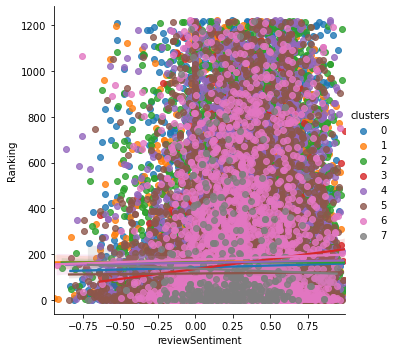

In [23]:
#Looks good. 
sns.lmplot(x='reviewSentiment', y = 'Ranking', data = x_train, hue = 'clusters')

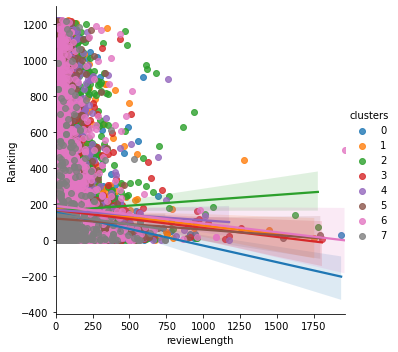

In [24]:
sns.lmplot(x='reviewLength', y = 'Ranking', data = x_train, hue = 'clusters')
#It looks like the ranking decreases as the reviews become increasingly verbose. 

In [25]:
#I'll go ahead and create an interaction term for cluster_reviewLength
x_train['clusterXreviewLength'] = x_train['clusters']*x_train['reviewLength']

Text(0.5, 1.0, 'Ranking vs Price varying by cluster')

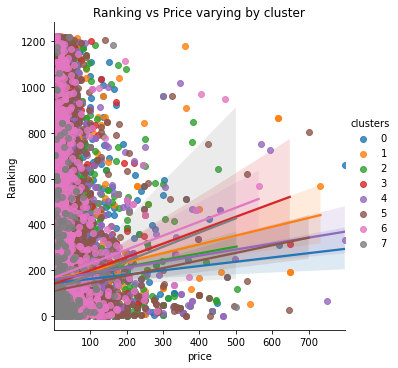

In [26]:
#Now I'll look for interaction terms using the clusters. 
#If the slopes or intercepts vary by cluster for ranking vs the other continuous variables then there are likely interactions
sns.lmplot(x = 'price', y = 'Ranking', hue = 'clusters', data = x_train)
plt.title('Ranking vs Price varying by cluster')

In [27]:
#There may also be an interaction between price and cluster. I'll create an interaction term there as well.
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs overall rating varying by cluster')

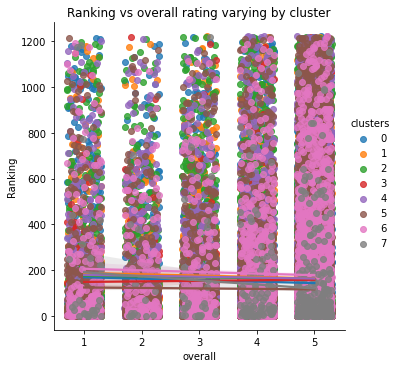

In [28]:
sns.lmplot(x = 'overall', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs overall rating varying by cluster')

In [29]:
#There may also be an interaction between cluster and overall
x_train['clusterXprice'] = x_train['clusters']*x_train['price']

Text(0.5, 1.0, 'Ranking vs AvgRating varying by cluster')

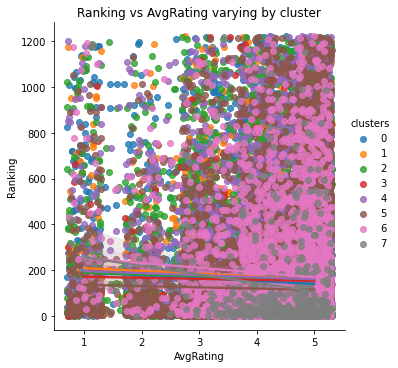

In [30]:
sns.lmplot(x = 'AvgRating', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('Ranking vs AvgRating varying by cluster')

In [31]:
#Create an interaction term between cluster and average rating
x_train['clusterXavgRating'] = x_train['clusters']*x_train['AvgRating']

Text(0.5, 1.0, 'salesRanking vs RatingCount varying by cluster')

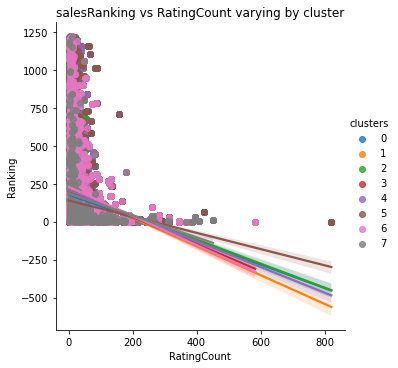

In [32]:
sns.lmplot(x = 'RatingCount', y = 'Ranking', hue = 'clusters', data = x_train, x_jitter = 0.3)
plt.title('salesRanking vs RatingCount varying by cluster')

In [33]:
#Create an interaction between RatingCount and clusters
x_train['clusterXratingCount'] = x_train['clusters']*x_train['RatingCount']

<AxesSubplot:>

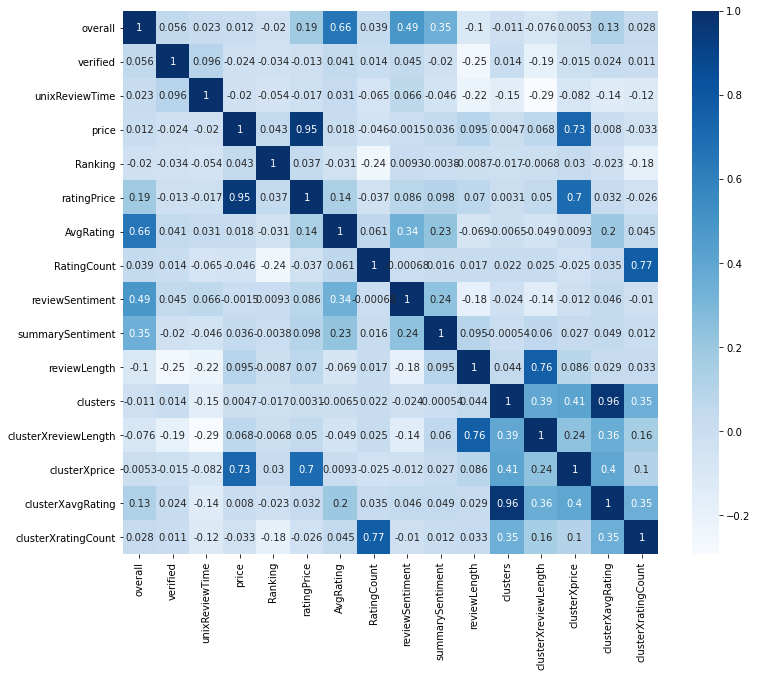

In [34]:
plt.figure(figsize = (12,10))
sns.heatmap(x_train.corr(), annot = True, cmap = 'Blues')


Now I'll need to predict the clusters for the training data as well as adding all of the additional features. It's important to use the PCA and KMeans that were fit to the training data to predict the test data. 

In [35]:
#Now I'll need to handle the categorical data. This means dropping some columns like reviewTime, reviewerID, asin, reviewerName
#reviewText, summary, category, catRank, rankCat. In the end, we need main_cat, brand and title.

x_train_categorical = pd.get_dummies(x_train[['main_cat']])

In [36]:
print('Categorical Dummies will add %d columns to the data' %x_train_categorical.shape[1])

Categorical Dummies will add 11 columns to the data


In [37]:
#Now that I have the dummy variables the dataset is huge. I'll try to reduce the dimensionality with PCA on the categorical variables
pca = PCA(n_components = 11)
pca.fit(x_train_categorical)
x_train_pca = pca.transform(x_train_categorical)

Text(0.5, 1.0, 'Scree Plot for Categorical Dummy Variables')

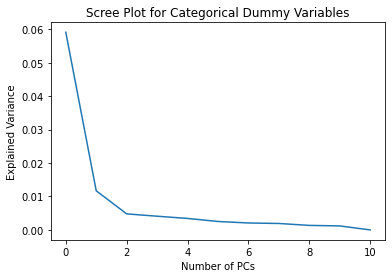

In [38]:
#I'll create a scree plot to extract the number of pertinent principle components.
plt.plot(pca.explained_variance_)
plt.xlabel('Number of PCs')
plt.ylabel('Explained Variance')
plt.title('Scree Plot for Categorical Dummy Variables')

In [39]:
x_train.shape

(59788, 29)

In [40]:
#It looks like I only need to include the first 2.
x_train_pca = pd.DataFrame(x_train_pca[:, 0:2], columns = ['PCA1', 'PCA2'])
# Add the columns to the training data.
x_train = pd.concat([x_train.reset_index(drop=True), x_train_pca.reset_index(drop = True)], axis=1)

In [41]:
x_train.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,category,...,reviewSentiment,summarySentiment,reviewLength,clusters,clusterXreviewLength,clusterXprice,clusterXavgRating,clusterXratingCount,PCA1,PCA2
0,5.0,1,"02 19, 2015",A20D3LGP09ZD1Z,B00JGWG0E8,Isabel Vera GB9544,The product its great Im. So happy whit them!,Five Stars,1424304000,"['Home & Kitchen', 'Kitchen & Dining', 'Storag...",...,0.635850,0.00000,9,4,36,143.96,20.000000,40.0,-0.053213,-0.004763
1,4.0,1,"06 28, 2015",A3R92NOECG3BIQ,B00K319R64,Sharon in Texas,I had a plastic sponge holder before this one ...,... holder before this one that finally broke ...,1435449600,"['Home & Kitchen', 'Kitchen & Dining', 'Storag...",...,0.111500,0.43640,50,4,200,23.96,16.000000,16.0,-0.053213,-0.004763
2,5.0,1,"01 23, 2015",AL2MQ5GYFBNJ4,B001TOTSNG,randee,These are great! They are really sturdy --- s...,Perfect!,1421971200,"['Home & Kitchen', 'Storage & Organization', '...",...,0.047567,0.61140,83,4,332,51.92,20.000000,20.0,-0.053213,-0.004763
3,5.0,1,"02 8, 2016",A2O64UXBK6PHU,B0000CFSMY,Wendy,Love them. Take 6 of these to use 1 full size...,Love them. Take 6 of these to use 1 ...,1454889600,"['Home & Kitchen', 'Kitchen & Dining', 'Bakewa...",...,0.170450,0.31845,21,2,42,22.56,9.333333,224.0,-0.053213,-0.004763
4,5.0,1,"09 18, 2016",AIILGRPK8IP6U,B018TVV7BW,Jenna,"Awesome cubes. Work perfect for storage, have ...",Buy these!,1474156800,"['Home & Kitchen', 'Storage & Organization', '...",...,0.598400,0.00000,14,0,0,0.00,0.000000,0.0,-0.053213,-0.004763


In [42]:
#First I'll add the clusters. I need to create a DF that drops the engineered features and the categorical features to train the KMeans model

obs = []
[obs.append(col) for col in x_test.columns if x_test[col].dtype == 'O']


#Predict the training clusters
x_test_clf = x_test.drop(obs, axis = 1)
pred_clusters = kmeans.predict(x_test_clf)
x_test['clusters'] = pred_clusters

In [43]:
#Create an interaction term for cluster_reviewLength
x_test['clusterXreviewLength'] = x_test['clusters']*x_test['reviewLength']

#Create an interaction between cluster and overall
x_test['clusterXprice'] = x_test['clusters']*x_test['price']

#Create an interaction term between cluster and average rating
x_test['clusterXavgRating'] = x_test['clusters']*x_test['AvgRating']

x_test['clusterXratingCount'] = x_test['clusters']*x_test['RatingCount']

In [44]:
x_test_categorical = pd.get_dummies(x_test[['main_cat']])
x_test_pca = pca.transform(x_test_categorical)
x_test_pca = pd.DataFrame(x_test_pca[:, 0:2], columns = ['PCA1', 'PCA2'])
x_test = pd.concat([x_test.reset_index(drop=True), x_test_pca.reset_index(drop=True)], axis = 1)

In [45]:
#Now check to ensure the dimensions and columns match
print('Dimensions of x_train are:', x_train.shape)
print('Dimensions of x_test are:', x_test.shape)
print('Coulmns of x_train are:', x_train.columns)
print('Columns of x_test are:', x_test.columns)

Dimensions of x_train are: (59788, 31)
Dimensions of x_test are: (19930, 31)
Coulmns of x_train are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'catRank',
       'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount', 'reviewSentiment',
       'summarySentiment', 'reviewLength', 'clusters', 'clusterXreviewLength',
       'clusterXprice', 'clusterXavgRating', 'clusterXratingCount', 'PCA1',
       'PCA2'],
      dtype='object')
Columns of x_test are: Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'category',
       'title', 'brand', 'rank', 'main_cat', 'price', 'rankCat', 'catRank',
       'Ranking', 'ratingPrice', 'AvgRating', 'RatingCount', 'reviewSentiment',
       'summarySentiment', 'reviewLength', 'clusters', 'clusterXreviewLength',
    

Now I'll just save the data with the new features. 

In [46]:
#Save the data to a csv file
x_train.to_csv('Data/x_train.csv', index = False)
y_train.to_csv('Data/y_train.csv', index = False)
x_test.to_csv('Data/x_test.csv', index = False)
y_test.to_csv('Data/y_test.csv', index = False)